<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SVM_Group_Adolescent_Whole_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

### Mount Google Drive and clone repository
- open to source directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


Cloning into 'teambrainiac'...
remote: Enumerating objects: 623, done.
remote: Counting objects: 100% (623/623), done.
remote: Compressing objects: 100% (439/439), done.
remote: Total 623 (delta 378), reused 344 (delta 168), pack-reused 0
Receiving objects: 100% (623/623), 66.48 MiB | 35.75 MiB/s, done.
Resolving deltas: 100% (378/378), done.
/content/teambrainiac/source
AccuracyMeasures.ipynb	  models
analysis.py		  process.py
cross_validation.py	  SingleSubjectSVM.ipynb
data			  SubjectVisualization_Models_ZNORM.ipynb
DL			  SVM_Group_Child_Whole_Brain.ipynb
Explore_data.ipynb	  SVM_Group_YA_Whole_brain.ipynb
explore.py		  train.py
Group_All_MASK_SVM.ipynb  utils.py
helper			  VisualizationPlayground.ipynb
Images			  Visualize_Data.ipynb
__init__.py


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [4]:
# Import libraries
!pip install boto3 nilearn
import pickle
from utils import *
from process import *
#from train import run_grp_svm_model
from cross_validation import *
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from collections import defaultdict
from sklearn.metrics import classification_report
import nibabel as nib

     |████████████████████████████████| 132 kB 25.5 MB/s 
     |████████████████████████████████| 10.1 MB 72.0 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 8.7 MB 59.5 MB/s 
     |████████████████████████████████| 138 kB 73.1 MB/s 
     |████████████████████████████████| 127 kB 80.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Load Data from AWS and create Train/Val/Test splits

In [5]:
%%time
pkl_file = "whole_brain_all_norm_2d.pkl" # normalized
bool_mat = False
data = access_load_data(pkl_file, bool_mat)

CPU times: user 52.7 s, sys: 1min 1s, total: 1min 53s
Wall time: 1min 47s


In [7]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']

# Split dataset intoyoung adults
ad = subject_ids[:33]
print("Number of subjects for Adolescent ", len(ad))

Number of subjects for Adolescent  33


##Time Series Cross Validation
### Organize Data Adolescent for Cross Validation
If we are performing cross validation, we need to get the data without custom splitting 

In [ ]:
%%time 

#Function Calls
group_sub_ids = ad 
runs_train = 1 # Grab run 2 (0 indexing)
runs_test = 2 # Grab run 3 (0 indexing)
norm = False #"RUNS", "SUBJECT", False 

X, y = data_for_cv(data, group_sub_ids, runs_train, runs_test, norm)

Normalizing Each based on False...
X train data shape after concantenation (2772, 237979)
y train data shape after concantenation (2772,)
X test data shape after concantenation (2772, 237979)
y test data shape after concantenation (2772,)
Final X data shape to feed into Time Series Cross Validation (5544, 237979)
Final y data shape to feed into Time Series Cross Validation (5544,)
CPU times: user 2.25 s, sys: 4.42 s, total: 6.67 s
Wall time: 6.62 s


### Run the Time Series Cross Validation

In [ ]:
max_train = 1596
test_size = None
splits = 5

time_series_cv(X, y, max_train, test_size, splits)

## SVM Adolescent
- Split subject IDs three ways to make Train, Val, Test sets
- Perform Z-Normalization on the data per run per subject by calling transform_data()
- Run SVM on PSC and Z-normalized Data
- Train/Val/Test set run 2 and 3

In [8]:
def run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, norm, svm_type):

  X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, norm)

  runs_id = [i+1 for i in runs_train]
  model_dict = defaultdict(list)

  model_name = f"{svm_type}_{runs_id}_{mask_type}_X_y_model"
  clf = SVC(C = 5.0 , class_weight= 'balanced', max_iter = 1000, random_state = 42) #probability = True
  print(f"Fitting the model for {mask_type}...")
  clf.fit(X, y)
  model_dict['model'].append(clf)
  model_dict['X_train'].append(X)
  model_dict["y_train"].append(y)

  s3_upload(model_dict, "models/group/%s.pkl"%model_name, 'pickle')
 
  print("Predicting on Validation set...")
  yval_pred = clf.predict(X_v)
  val_acc = accuracy_score(y_v, yval_pred)
  print("Validation Accuracy:", val_acc)

  print("Predicting on Test set...")
  ytest_pred = clf.predict(X_t)
  test_acc = accuracy_score(y_t, ytest_pred)
  print("Test Accuracy:", test_acc)

  # Save metrics for individual masks
  type_report = ['validation_classreport', 'test_classreport']
  for report in type_report:
    if report == 'validation_classreport':
      class_report = classification_report(y_v, yval_pred, output_dict = True)
      class_report.update({"accuracy": {"precision": None, "recall": None, 
                                    "f1-score": class_report["accuracy"], 
                                    "support": class_report['macro avg']['support']}})
      df = pd.DataFrame(class_report).T

    elif report == 'test_classreport':
      class_report = classification_report(y_t, ytest_pred, output_dict = True)
      class_report.update({"accuracy": {"precision": None, "recall": None, 
                                    "f1-score": class_report["accuracy"], 
                                    "support": class_report['macro avg']['support']}})
      df = pd.DataFrame(class_report).T

    s3_upload(df, f"metrics/group_svm/{svm_type}_{runs_id}_{mask_type}_{report}.csv", "csv")
    print(f"Classification report for {mask_type} {report}")
    print(classification_report(y_v, yval_pred))

  #Return X train and clf for visualization
  return model_dict

In [9]:
# get train, test val data
train_ids = ad[:23]
val_ids = ad[23:28]
test_ids = ad[28:34]

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = [1,2]
runs_test = [1,2] #2 # grabds the third run
norm = "RUNS" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization
mask_type = 'whole_brain'
svm_type = "Adolescent"


print("Number of Adolescent training examples: ", len(train_ids))
print("Number of Adolescent validation examples: ", len(val_ids))
print("Number of Adolescent testing examples: ", len(test_ids))
print(len(ad))

model_dict = run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, norm, svm_type)

Number of Adolescent training examples:  23
Number of Adolescent validation examples:  5
Number of Adolescent testing examples:  5
33
Normalizing Each based on RUNS...
Final X Train data shape (3864, 237979)
Final y Train data shape  (3864,)
Final X Val data shape (840, 237979)
Final y Val data shape  (840,)
Final X Test data shape (840, 237979)
Final y Test data shape  (840,)
Fitting the model for whole_brain...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


upload complete for models/group/Adolescent_[2, 3]_whole_brain_X_y_model.pkl
Predicting on Validation set...
Validation Accuracy: 0.7238095238095238
Predicting on Test set...
Test Accuracy: 0.7547619047619047
upload complete for metrics/group_svm/Adolescent_[2, 3]_whole_brain_validation_classreport.csv
Classification report for whole_brain validation_classreport
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       420
           1       0.71      0.75      0.73       420

    accuracy                           0.72       840
   macro avg       0.72      0.72      0.72       840
weighted avg       0.72      0.72      0.72       840

upload complete for metrics/group_svm/Adolescent_[2, 3]_whole_brain_test_classreport.csv
Classification report for whole_brain test_classreport
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       420
           1       0.71      0.75      0.73       420



## Visualization Analysis
- Load SVM pretrained model
- Load X train data and labels
- Check Support Vectors
- Create Alphas from dual coefficients/model weights and load into support vector indices
- Take the dot product of alphas and X train data and create a bmap
- Using the bmap we recreate the 4D space using 3d mask indices and load the dot product of alphas and X train information into this matrix
- Use this information to visualize the areas of the brain that were learned by the SVM to be areas close to the decision boundary, areas thought of as either upregulating or downregulating

In [10]:
# Load model
#model_dict = access_load_data('models/group/Adolescent_[2, 3]_whole_brain_X_y_model.pkl', False)
print(model_dict.keys())
clf = model_dict['model'][0]
X = model_dict['X_train'][0]
y = model_dict['y_train'][0]

dict_keys(['model', 'X_train', 'y_train'])


In [11]:
print("number of support vectors:", len(clf.support_))
print("indices of support vectors:", clf.support_)
print("support vector shape: ", clf.support_vectors_.shape)
print("number of support vectors for each class:", clf.n_support_)
print("# Values scaled to fit between -1 and 1:", clf.dual_coef_.shape)
print("length of X-train:", len(X))

number of support vectors: 1983
indices of support vectors: [  14   16   28 ... 3850 3852 3856]
support vector shape:  (1983, 237979)
number of support vectors for each class: [999 984]
# Values scaled to fit between -1 and 1: (1, 1983)
length of X-train: 3864


#### Create Beta map for Visualization
- Create Alphas and Bmaps

In [12]:
# Load in affine matrix - helps map the data coordinates to real world coordinates
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('single_subj_T1_resampled.nii',False)

# Load in the mask indices to create bmaps
mask_data_path = data_path_dict['mask_data'][0]
mask_type_dict = access_load_data(mask_data_path, True)
np_array_mask = mask_type_dict['mask']
print("mask shape:", np_array_mask.shape)
indices_mask = np.where(np_array_mask==1) # gets the indices where the mask is 1, the brain region for x, y, z planes

mask shape: (79, 95, 79)


In [13]:
def create_bmaps(clf, X, y, indices_mask, image):

  # Create alpha matrix and map weights to support vector indices
  alphas1 = np.zeros((len(X)))
  alphas1[clf.support_] = clf.dual_coef_ #Load the weights corresponding to where support vectors are 

  alphas2 = alphas1.reshape(1,-1)
  bmap = np.dot(alphas2, X)
  #print("Shape of beta map: ", bmap.shape)

  # Grab the areas not masked out of the brain to recreate the brain using highlighted areas
  bmap2 = np.zeros((79,95,79))
  bmap2[indices_mask] = bmap

  bmap3 = nib.Nifti1Image(bmap2, affine = affine_image.affine, header = affine_image.header)
  return bmap3, bmap2, alphas1

bmap3, bmap2, alphas1 = create_bmaps(clf, X, y, indices_mask, affine_image)

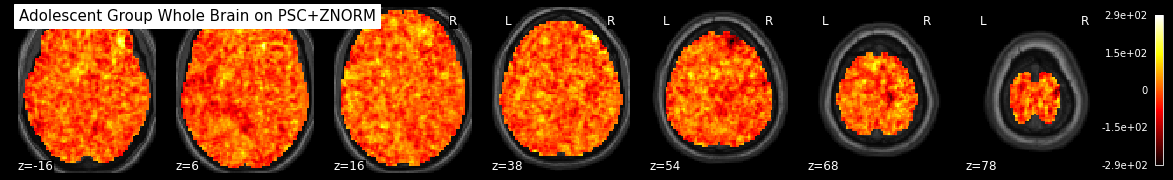

In [14]:
from nilearn import plotting, image

display = plotting.plot_stat_map(bmap3, bg_img = t1_image,
                              colorbar=True, cmap='hot', display_mode='z',
                              title=f"Adolescent Group Whole Brain on PSC+ZNORM")

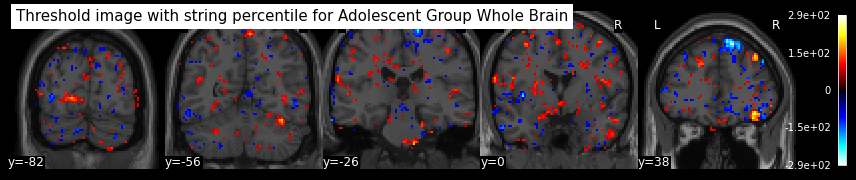

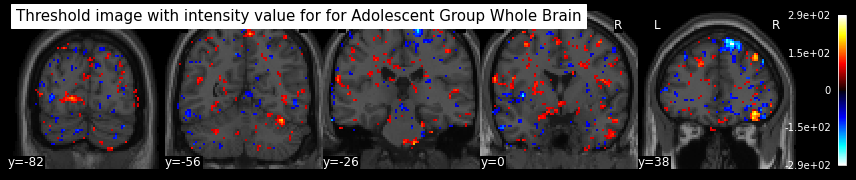

In [15]:
from nilearn.image import threshold_img
#def get_threshold_image(bmap3):
# Two types of strategies can be used from this threshold function
# Type 1: strategy used will be based on scoreatpercentile
threshold_percentile_img = threshold_img(bmap3, threshold='98%', copy=False)


# Type 2: threshold strategy used will be based on image intensity
# Here, threshold value should be within the limits i.e. less than max value.
threshold_value_img = threshold_img(bmap3, threshold=3.0, copy=False)
#return threshold_percentile_img, threshold_value_img


#threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3)

plotting.plot_stat_map(threshold_percentile_img, bg_img = t1_image, display_mode='y', cut_coords=5,
                    title=f'Threshold image with string percentile for Adolescent Group Whole Brain', colorbar=True)

# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, bg_img = t1_image, display_mode='y', cut_coords=5,
                    title=f'Threshold image with intensity value for for Adolescent Group Whole Brain', colorbar=True)

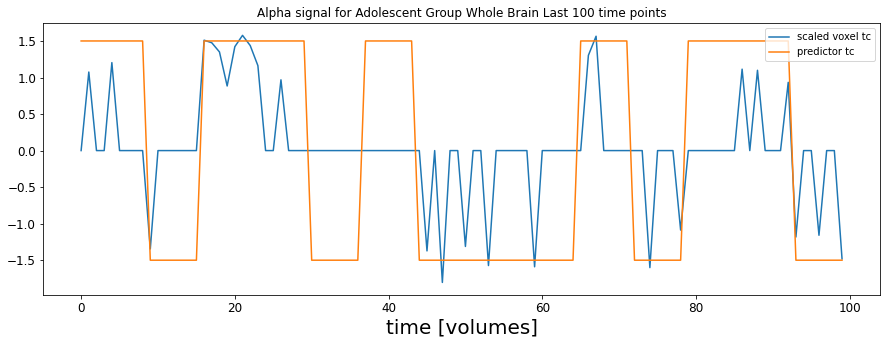

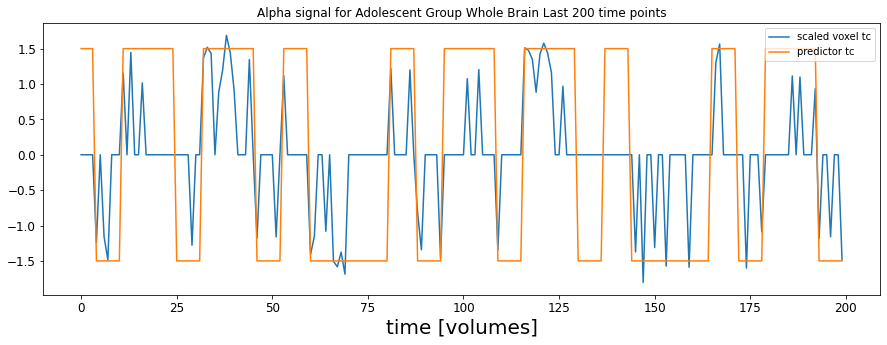

In [18]:
import matplotlib.pyplot as plt

def plot_alphas(alphas,alpha_labels, time):
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, label='scaled voxel tc')
  ax.plot(alpha_labels,  label='predictor tc')
  #ax.set_xlim(0, acq_num-1)
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(f"Alpha signal for Adolescent Group Whole Brain Last {time} time points")
  ax.legend(loc = 'upper right')
  plt.show()

#
timepoints = [(100, -1.5, 1.5), (200, -1.5, 1.5)]
for time, min, max in timepoints:
  alpha_labels = np.where(y == 0,min,max)
  plot_alphas(alphas1[-time:],alpha_labels[-time:], time)



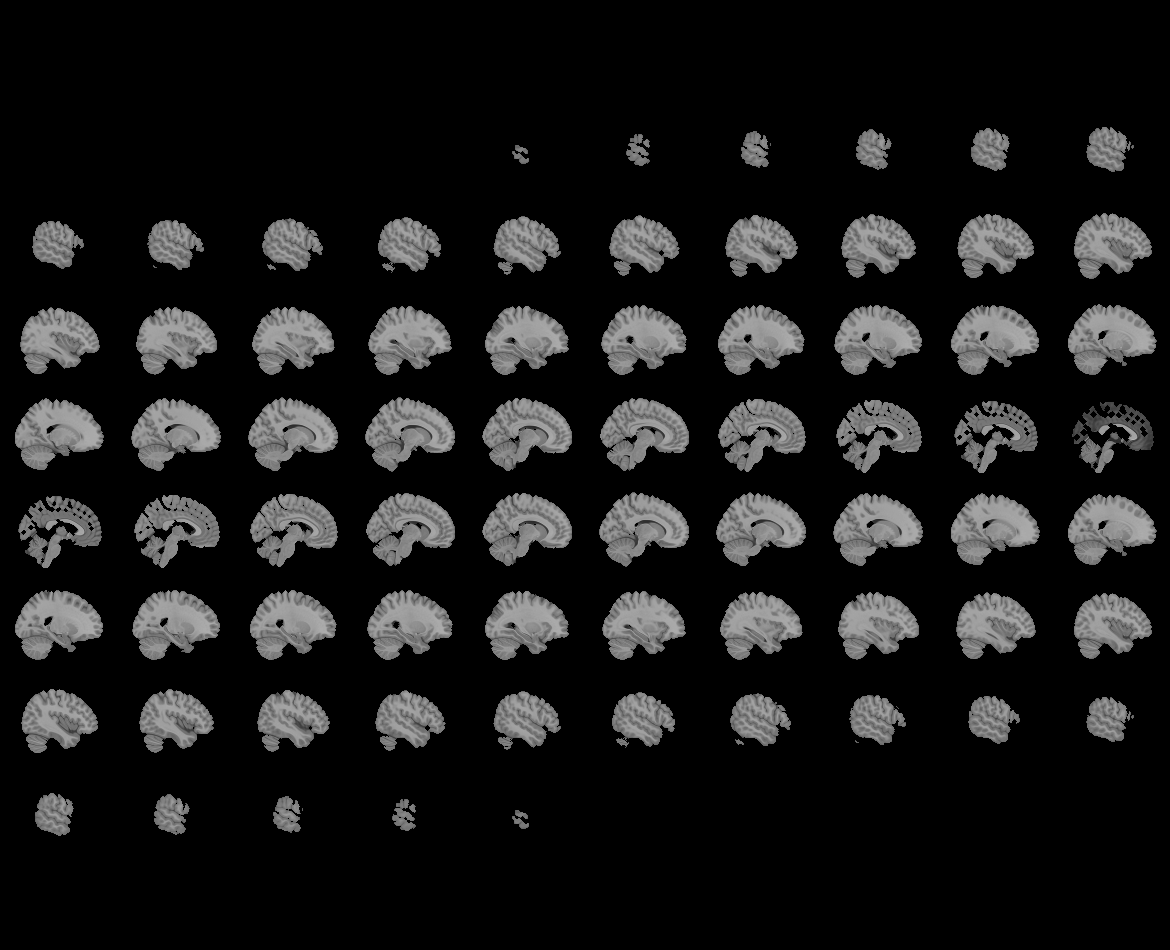
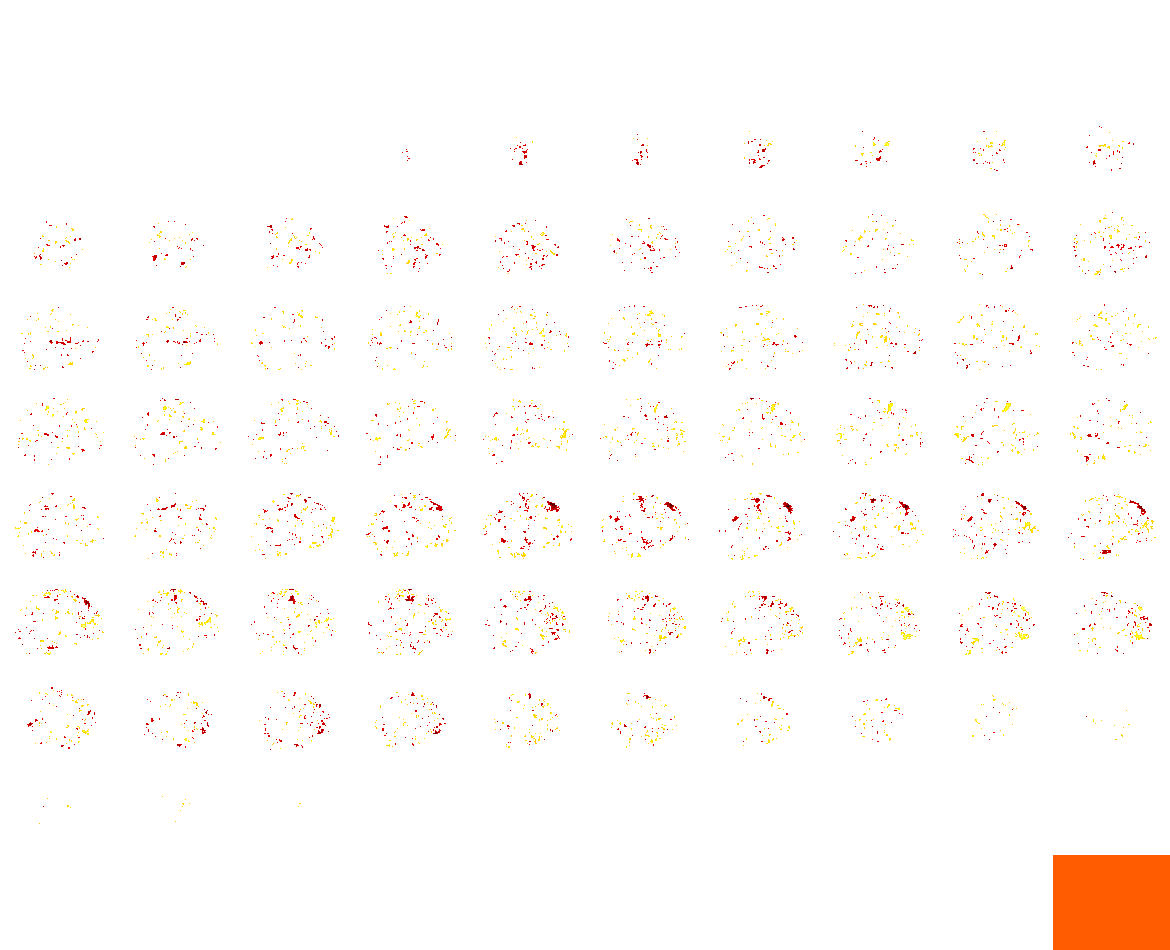

In [20]:
from nilearn import plotting, datasets     
html_view = plotting.view_img(bmap3, bg = t1_image, threshold='98%', cmap = 'hot', cut_coords=[-10, 13, -8],
                                    title="Motor contrast")
html_view

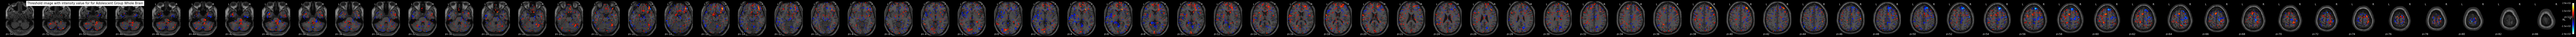

In [21]:
# Showing intensity threshold image

plotting.plot_stat_map(threshold_percentile_img, bg_img = t1_image, display_mode='z', cut_coords=79, annotate = True,
                    title=f'Threshold image with intensity value for for Adolescent Group Whole Brain', colorbar=True)

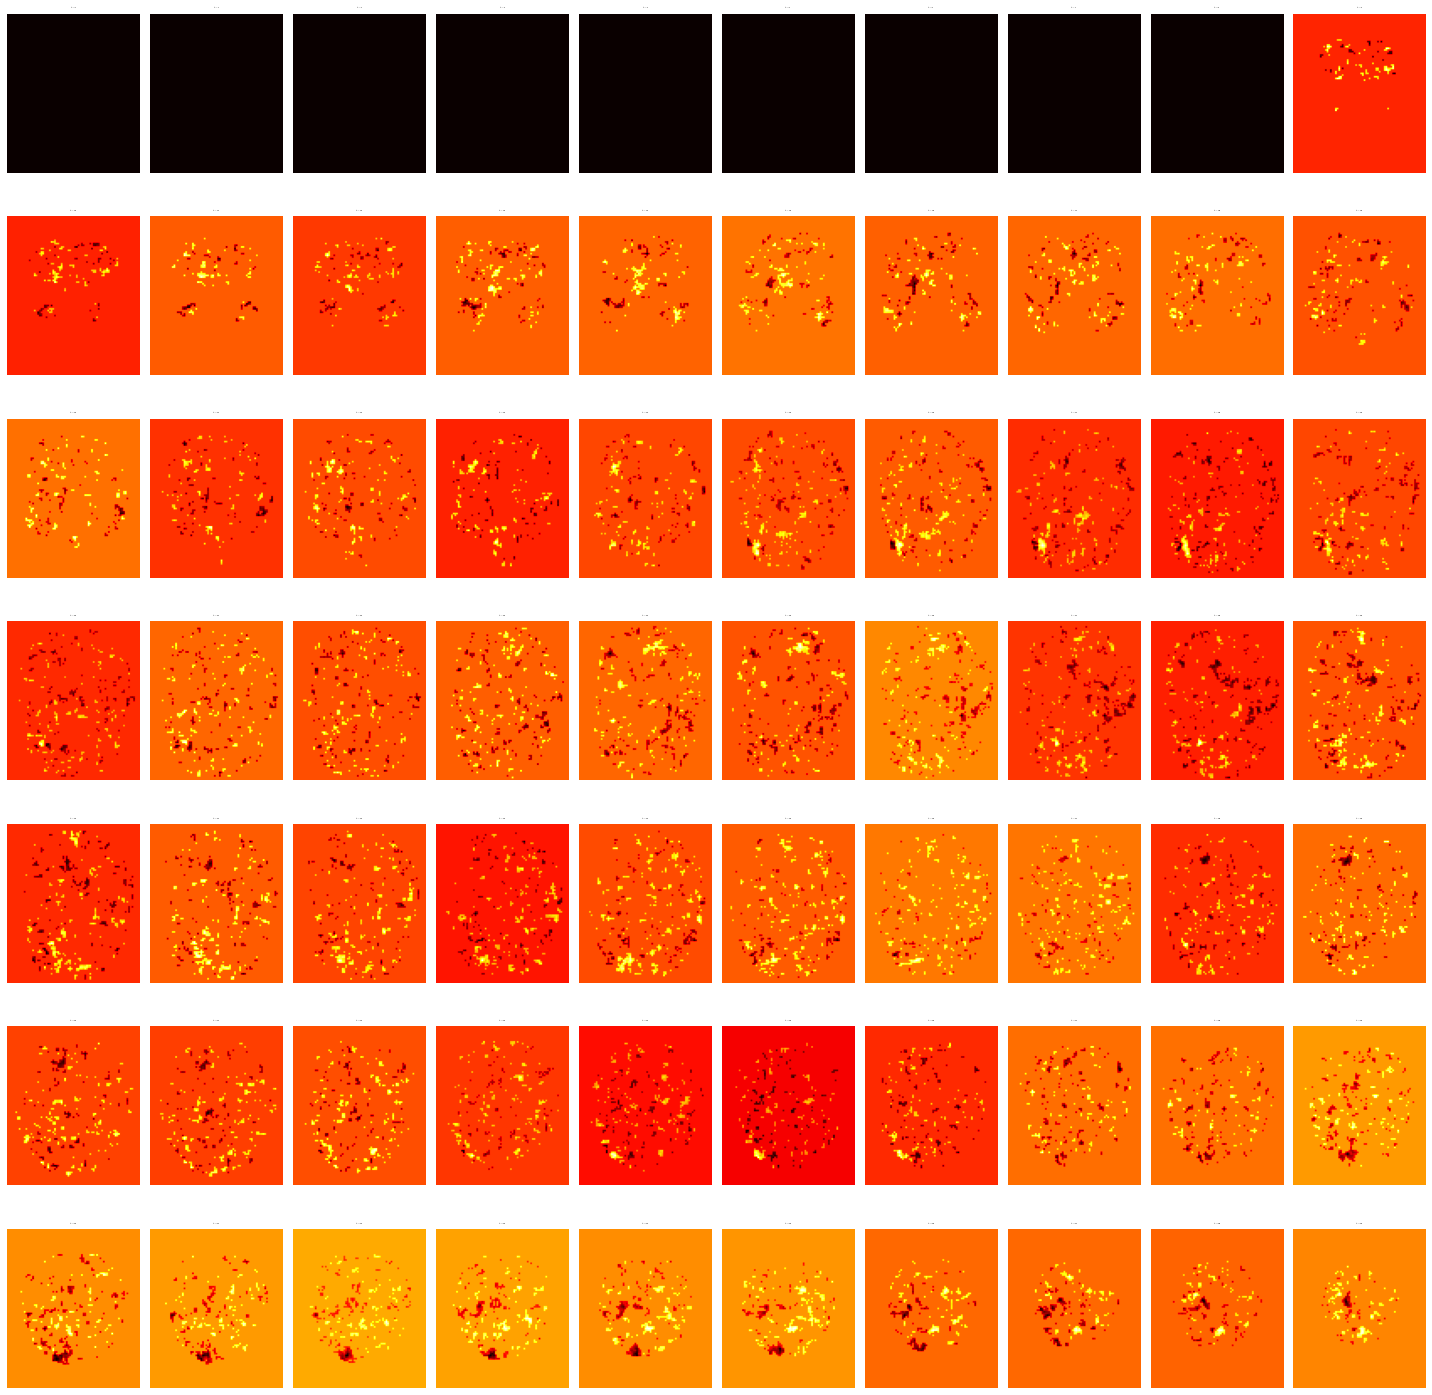

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=10, nrows=7, figsize=(20, 20))  # 70 slices
# Loop over the first 70 slices
for t, ax in enumerate(axes.flatten()):   
    ax.imshow(bmap2[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.tight_layout()

In [23]:
## Cross Validation accuracy scores recorded

dictionary = {"Cross Validation Adolescent Train run 2/Test run 3": ["1","2","3","4","5","Average"], 
              "Unnormalized": [.50, .51, .50, .50, .50, .50],
              "PSC per run": [.53, .63, .50, .50, .59, .55 ], 
              "PSC + Z Norm per Subject": [.63, .72, .62, .58, .52, .61], 
              "PSC + Z Norm per Run": [.68, .75, .73, .71, .77, .73], 
              "Z Norm per Run (No PSC)": [.62, .71, .72, .65, .63, .67]
              }

df = pd.DataFrame(dictionary)
df.set_index("Cross Validation Adolescent Train run 2/Test run 3", inplace = True)
df

,Unnormalized,PSC per run,PSC + Z Norm per Subject,PSC + Z Norm per Run,Z Norm per Run (No PSC)
Cross Validation Adolescent Train run 2/Test run 3,,,,,
1,0.50,0.53,0.63,0.68,0.62
2,0.51,0.63,0.72,0.75,0.71
3,0.50,0.50,0.62,0.73,0.72
4,0.50,0.50,0.58,0.71,0.65
5,0.50,0.59,0.52,0.77,0.63
Average,0.50,0.55,0.61,0.73,0.67
